# Simplified ZZ analysis

This is based on the ZZ analysis in the ATLAS outreach paper, but including all possible pairs of muons rather than selecting the combination closest to the Z mass.

This time we will use ROOT histograms instead of Matplotlib:

In [1]:
from ROOT import TChain, TH1F, TLorentzVector, TCanvas

Welcome to ROOTaaS 6.06/06


Use some Monte Carlo ZZ events for testing before running on real data:

In [2]:
data = TChain("mini");  # "mini" is the name of the TTree stored in the data files
data.Add("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/MC/mc_105986.ZZ.root")
#data.Add("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/Data/DataMuons.root")

1

Define a class and some functions that we can use for extracting the information we want from the events:

In [3]:
class Particle:
    '''
    Represents a particle with a known type, charge and four-momentum
    '''
    def __init__(self, four_momentum, pdg_code, charge):
        self.four_momentum = four_momentum
        self.typ = abs(pdg_code)
        self.charge = charge

def leptons_from_event(event, pt_min=0.0):
    '''
    Gets list of leptons from an event, subject to an optional minimum pT cut.
    '''
    leptons = []
    for i in xrange(event.lep_n):
        pt = event.lep_pt[i]
        if pt > pt_min:        # only add lepton to output if it has enough pt
            p = TLorentzVector()
            p.SetPtEtaPhiE(pt, event.lep_eta[i], event.lep_phi[i], event.lep_E[i])
            particle = Particle(p, event.lep_type[i], event.lep_charge[i])
            leptons.append(particle)
    return leptons

def pairs_from_leptons(leptons):
    '''
    Get list of four-momenta for all possible opposite-charge pairs.
    '''
    neg = []
    pos = []
    for lepton in leptons:
        if lepton.charge > 0:
            pos.append(lepton)
        elif lepton.charge < 0:
            neg.append(lepton)
        else:
            print("Warning: unexpected neutral particle")
    pairs = []
    for p in pos:
        pp = p.four_momentum
        for n in neg:
            if p.typ == n.typ:    # only combine if they are same type (e or mu)
                pn = n.four_momentum
                ptot = pp + pn
                pairs.append(ptot)
    return pairs

Now we can look for events with exactly four "good" leptons (those with a big enough pT) and combine them in pairs to make Z candidates:

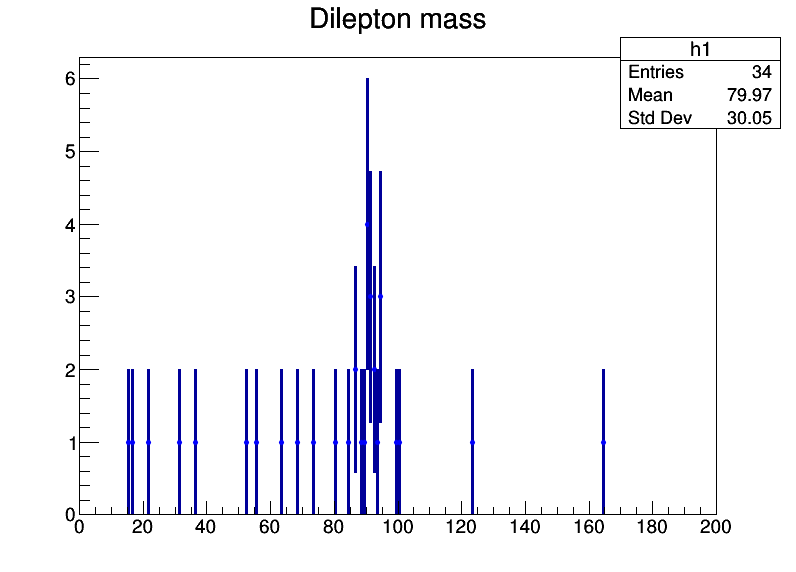

In [4]:
c1 = TCanvas("TheCanvas","Canvas for plotting histograms",800,600)
h1 = TH1F("h1","Dilepton mass",200,0,200)

num_events = data.GetEntries()

for event_num in xrange(1000):               # loop over the events
    data.GetEntry(event_num)                 # read the next event into memory
    leptons = leptons_from_event(data,10000) # pt cut of 10 GeV
    if len(leptons) == 4:                    # require exactly 4 "good" leptons
        pairs = pairs_from_leptons(leptons)
        for pair in pairs:
            m = pair.M()/ 1000.   # convert from MeV to GeV
            h1.Fill(m)
        
h1.Draw('E')
c1.Draw()